In [ ]:
#default_exp data.datasets.tourismL

# TourismLarge dataset.

## Dataset Description
This detailed Australian Tourism Dataset comes from the National Visitor Survey, managed by the Tourism Research Australia, it is composed of 555 monthly series from 1998 to 2016, it is organized geographically, and purpose of travel. The natural geographical hierarchy comprises seven states, divided further in 27 zones and 76 regions. The purpose of travel categories are holiday, visiting friends and relatives (VFR), business and other. The MinT (Wickramasuriya et al., 2019), among other hierarchical forecasting studies has used the dataset it in the past. The dataset can be accessed in the [MinT reconciliation webpage](https://robjhyndman.com/publications/mint/), official sources are also available.

Table of Contents
1.   [Auxiliary Functions](#cell-1)
2.   [TourismL Class](#cell-2)
3.   [TourismL Validation](#cell-3)
4.   [HierarchicalDataset Class](#cell-4)
5.   [HierarchicalDataset Validation](#cell-5)


Summary of TourismL's hierarchical structure

| Geographical Division | Number of series per division | Number of series per purpose | Total |
|          ---          |               ---             |              ---             |  ---  |
|  Australia            |              1                |               4              |   5   |
|  States               |              7                |              28              |  35   |
|  Zones                |             27                |              108             |  135  |
|  Regions              |             76                |              304             |  380  |
|  Total                |            111                |              444             |  555  |


Total and States:

| Series | Name         | Label     |
|---     |---           |---        |
|  1     |  Australia   |   Total   |
|  2     |  NSW         |   A       |
|  3     |  VIC         |   B       |
|  4     |  QLD         |   C       |
|  5     |  SA          |   D       |
|  6     |  WA          |   E       |
|  7     |  TAS         |   F       |
|  8     |  NT          |   G       |

In [ ]:
# export
import os
import gc
import copy
import timeit
import zipfile
from pathlib import Path
from collections import defaultdict
from collections import OrderedDict

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

from dataclasses import dataclass
from neuralforecast.data.datasets.utils import (
    download_file, Info, TimeSeriesDataclass
)

In [ ]:
# hide
import matplotlib.pyplot as plt

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')

from matplotlib import rcParams
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 22

<a name="cell-1"></a>
## 1. Auxiliary Functions

In [ ]:
# export
class CodeTimer:
    def __init__(self, name=None, verbose=True):
        self.name = " '"  + name + "'" if name else ''
        self.verbose = verbose

    def __enter__(self):
        self.start = timeit.default_timer()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (timeit.default_timer() - self.start)
        if self.verbose:
            print('Code block' + self.name + \
                  ' took:\t{0:.5f}'.format(self.took) + ' seconds')

In [ ]:
# export
def one_hot_encoding(df, index_col):    
    encoder = OneHotEncoder()
    columns = list(df.columns)
    columns.remove(index_col)
    one_hot_concat_df = pd.DataFrame(df[index_col].values, columns=[index_col])
    for col in columns:
        dummy_columns = [f'{col}_[{x}]' for x in list(df[col].unique())]
        dummy_values  = encoder.fit_transform(df[col].values.reshape(-1,1)).toarray()
        one_hot_df    = pd.DataFrame(dummy_values, columns=dummy_columns)        
        one_hot_concat_df = pd.concat([one_hot_concat_df, one_hot_df], axis=1)
    return one_hot_concat_df

def nonzero_indexes_by_row(M):
    return [np.nonzero(M[row,:])[0] for row in range(len(M))]

<a name="cell-2"></a>
## 2. TourismL Class

In [ ]:
# export
@dataclass
class TourismL(TimeSeriesDataclass):
    
    url = 'https://robjhyndman.com/publications/mint/'
    source_url = 'https://robjhyndman.com/data/TourismData_v3.csv'
    H = 12

    @staticmethod
    def load(directory: str):
        """
        Downloads and loads TourismL data.

        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
            
        Returns
        -------
        df: pd.DataFrame
            Target time series with columns ['unique_id', 'ds', 'y'].
        """
        
        TourismL.download(directory)
        
        file = f'{directory}/TourismData_v3.csv'
        if not os.path.exists(file):
            raise ValueError(
                "TourismL zip file not found in {}!".format(file) +
                " Please manually download from {}".format(TourismL.url))
        
        # Fixing original dataset dates
        df = pd.read_csv(file)
        df['ds'] = np.arange("1998-01-01","2017-01-01",dtype='datetime64[M]')
        df = df.drop(labels=['Year', 'Month'], axis=1)
        
        # Add aditional H steps for predictions
        # declare skipping ds from column names
        extra = np.empty((12,len(df.columns)-1,))
        extra[:] = np.nan
        extra_df = pd.DataFrame.from_records(extra, columns=df.columns[1:]) 
        extra_df['ds'] = np.arange("2017-01-01","2018-01-01",dtype='datetime64[M]')
        
        raw_df = pd.concat([df, extra_df], axis=0).reset_index(drop=True)
        
        return raw_df
        
    @staticmethod
    def download(directory: str) -> None:
        """
        Download M3 Dataset.
        
        Parameters
        ----------
        directory: str
            Directory path to download dataset.
        """
        path = f'{directory}'
        if not os.path.exists(path):
            download_file(path, TourismL.source_url)
            
    @staticmethod
    def preprocess_data(directory: str, verbose=False) -> None:
        # Read raw data and create ids for later use
        raw_df = TourismL.load(directory)
        dates = raw_df.ds        
        raw_df.drop(['ds'], axis=1, inplace=True)
        unique_ids  = np.array(list(raw_df.columns)) 
        region_ids  = np.array([u_id[:3] for u_id in unique_ids]) #AAAHol->AAA
        purpose_ids = np.array([u_id[3:] for u_id in unique_ids]) #AAAHol->Hol
        
        with CodeTimer('Create static_agg', verbose):
            # Create static features df, 
            # 1 country, 7 States, 27 Zones, 76 Regions
            H_df = pd.DataFrame({'unique_id': unique_ids})
            H_df['country'] = 'Australia'                 # 1
            H_df['state']   = H_df['unique_id'].str[:1]   # 7
            H_df['zone']    = H_df['unique_id'].str[:2]   # 27
            H_df['region']  = H_df['unique_id'].str[:3]   # 76

            # GeographyXpurpose fixed effects
            # 4 countryXpurpose, 28 StatesXpurpose, 
            # 108 ZonesXpurpose, 304 RegionsXpurpose (unique_id)
            H_df['purpose']       = H_df['unique_id'].str[-3:]      # 4
            H_df['state_purpose'] = H_df['state'] + H_df['purpose'] # 28
            H_df['zone_purpose']  = H_df['zone'] + H_df['purpose']  # 108

            # Hierarchical aggregation matrix
            Hencoded = one_hot_encoding(df=H_df, index_col='unique_id')
            Hsum = Hencoded.values[:, 1:].T # Eliminate unique_id index
            H = np.concatenate((Hsum, np.eye(len(unique_ids))), axis=0)

            # Final wrangling + save
            # Create aggregate(region) level dummy variables
            H_df_agg  = H_df[['region', 'country', 'state', 'zone']]
            H_df_agg  = H_df_agg.drop_duplicates()
            static_agg = one_hot_encoding(df=H_df_agg, index_col='region')

        with CodeTimer('Create temporal_agg', verbose):
            #----------------------- Y Variables -----------------------#
            
            # Hierarchical Y for Y_agg features
            Y_bottom = raw_df.values.T
            Y_hier    = H @ Y_bottom      # [n_agg+n_bottom, n_bottom] x [n_bottom, T]

            # [Total, State, Zone, Region, TotalP, StateP, ZoneP] [0, 1, 2, 3, 4, 5, 6]
            # [Total, State, Zone, Region] <--> [0, 1, 2, 3]
            # [TotalP, StateP, ZoneP, RegionP] <--> [4, 5, 6]
            Y_agg_idxs = nonzero_indexes_by_row(Hsum.T)
            Y_agg  = np.stack([Y_hier[idx, :].T for idx in Y_agg_idxs ])
            Y_agg  = Y_agg[:,:,[0, 1, 2, 3]]

            # Keep total geographic visits, erase redundant purpose
            n_groups = len(H_df.region.unique())
            n_purposes = len(H_df.purpose.unique())
            n_time = len(dates)
            n_agg = Y_agg.shape[-1]
            Y_agg    = Y_agg.reshape((n_groups,n_purposes,n_time,n_agg))
            Y_agg    = Y_agg[:,0,:,:] # Skip redundant purpose dimension

            #----------------------- X variables -----------------------#
            # Calendar variables December distance
            calendar_df = pd.DataFrame()
            calendar_df['ds'] = dates
            calendar_df['distance_month'] = calendar_df.ds.dt.month
            # December/January? spike match and normalization of month distance
            calendar_df['distance_month'] = (calendar_df['distance_month'] - 3) % 12
            calendar_df['distance_month'] = (calendar_df.distance_month) / 11.0 - 0.5
            distance_month = calendar_df.distance_month.values
            distance_month = np.tile(distance_month, (76,1))
            X_agg = np.tile(calendar_df.values, (76,1,1))
            
            # Final wrangling + save
            temporal_agg = np.concatenate([X_agg, Y_agg], axis=2)
            temporal_agg = temporal_agg.reshape(-1, temporal_agg.shape[-1])
            temporal_agg = pd.DataFrame.from_records(temporal_agg,
                                     columns=['ds', 'distance_month',
                                              'y_[total]', 'y_[state]', 
                                              'y_[zone]', 'y_[region]'])
            temporal_agg['region'] = np.tile(static_agg.region.values[:,None], (240,1))
            
        with CodeTimer('Create static_bottom', verbose):
            # This version intends to help the model learn in this low sample task
            # Providing it with precomputed level/spread will model to "level" predictions
            # Some ideas to try:
            # 1) seasonal levels
            # 2) robust vs non robust levels and spreads
            # 3) like moving average, compute this metrics filtering the available data.
            
            # Create S_bottom matrix (previous static features)
            # S_bottom   = H[:n_agg, :].T

            # Avoid leakage into statistics and collapse time dimension, 
            # using median (it is robust to outliers)    
            Y_available = Y_bottom[:,:-12-12] # skip test and validation

            # [n_regions*n_purpose, n_time] --> [n_regions*n_purpose]
            level  = np.median(Y_available, axis=1)
            spread = np.median(np.abs(Y_available - level[:,None]), axis=1)

            # Seasonal levels
            Y_december = Y_available.reshape(304,18,12)[:,:,0]
            Y_january  = Y_available.reshape(304,18,12)[:,:,-1]
            december_level = np.median(Y_december/(level[:,None]+1), axis=1)
            january_level  = np.median(Y_january/(level[:,None]+1), axis=1)

            # Final wrangling + save
            static_bottom = np.concatenate([level[:,None], spread[:,None],
                                           december_level[:,None], 
                                           january_level[:,None]], axis=1)
            static_bottom = pd.DataFrame.from_records(static_bottom, 
                                        columns=['level', 'spread', 
                                                 'level_[december]', 
                                                 'level_[january]'])
            static_bottom['unique_id'] = unique_ids
            static_bottom['region']    = region_ids
            static_bottom['purpose']   = purpose_ids

        with CodeTimer('Create temporal_bottom', verbose):
            # To help the model learn seasonalities(12 months)
            # we compute lag 12 for 304 regions x purposes
            # Elements that roll beyond the last position are re-introduced at the first.
            Y_lags = np.roll(Y_bottom, shift=12, axis=1)
            Y_lags[:,:12] = Y_lags[:,12:24] # Clean raw_df NAs from first 12 entries

            # December/January dummy variables
            encoder = OneHotEncoder()
            month_cols = [f'month_[{str(x+1)}]' for x in range(12)]
            month_df = calendar_df['distance_month'].values.reshape(-1,1)
            month_df = encoder.fit_transform(month_df).toarray()
            month_df = pd.DataFrame(month_df, columns=month_cols)
            month_df['ds'] = calendar_df['ds']
            
            # Available and sample masks
            month_df['available_mask'] = 1
            month_df['sample_mask']    = 1
            
            month_df = month_df[['ds', 'month_[11]', 'month_[12]',
                                 'available_mask', 'sample_mask']]       # Filter, Dec/Jan
            month_bottom = np.tile(month_df.values[None,:,:], (304,1,1)) # Dummies for each serie
            
            # Final wrangling + save
            temporal_bottom = np.concatenate([month_bottom, Y_lags[:,:,None]], axis=2)
            temporal_bottom = np.concatenate([temporal_bottom, Y_bottom[:,:,None]], axis=2)
            temporal_bottom = temporal_bottom.reshape(-1, temporal_bottom.shape[-1])
            temporal_bottom = pd.DataFrame.from_records(temporal_bottom, 
                                        columns=list(month_df.columns) + \
                                                ['y_[lag12]', 'y',])
            temporal_bottom['unique_id'] = np.repeat(unique_ids, 240)
            temporal_bottom['region']    = np.repeat(region_ids, 240)
            temporal_bottom['purpose']   = np.repeat(purpose_ids,240)
        
        # Checking dtypes correctness
        if verbose:
            print('1. static_agg.dtypes \n', static_agg.dtypes)
            print('2. temporal_agg.dtypes \n', temporal_agg.dtypes)
            print('3. static_bottom.dtypes \n', static_bottom.dtypes)
            print('4. temporal_bottom.dtypes \n', temporal_bottom.dtypes)
        
        # Save feathers for fast access
        H_df.to_feather(f'{directory}/H_df.feather')
        static_agg.to_feather(f'{directory}/static_agg.feather')
        temporal_agg.to_feather(f'{directory}/temporal_agg.feather')        
        static_bottom.to_feather(f'{directory}/static_bottom.feather')
        temporal_bottom.to_feather(f'{directory}/temporal_bottom.feather')
    
    @staticmethod
    def load_process(directory=str, verbose=False) -> None:
                
        #-------------------------------------- S/X/Y_agg    --------------------------------------#
        with CodeTimer('Reading data   ', verbose):
            static_agg    = pd.read_feather(f'{directory}/static_agg.feather')
            temporal_agg    = pd.read_feather(f'{directory}/temporal_agg.feather')

            static_bottom = pd.read_feather(f'{directory}/static_bottom.feather')
            temporal_bottom = pd.read_feather(f'{directory}/temporal_bottom.feather')
            
            # Extract datasets dimensions for later use
            dates = pd.to_datetime(temporal_agg.ds.unique())
            unique_ids  = static_bottom.unique_id.values
            region_ids  = static_bottom.region.values
            purpose_ids = static_bottom.purpose.values
            n_time   = len(dates)                             # 228
            n_group  = len(static_bottom.region.unique())     # 76
            n_series = len(static_bottom.purpose.unique())    # 4
            
        with CodeTimer('Process temporal_agg', verbose):
            # Drop observation indexes and obtain column indexes
            temporal_agg.drop(['region', 'ds'], axis=1, inplace=True)
            xcols_agg       = temporal_agg.columns
            xcols_hist_agg  = ['y_[total]', 'y_[state]', 'y_[zone]', 'y_[region]']
            xcols_futr_agg  = ['distance_month']
        
            X_agg  = temporal_agg.values
            Y_agg  = temporal_agg[['y_[total]', 'y_[state]', 
                                'y_[zone]', 'y_[region]']].values

            X_agg  = X_agg.reshape((n_group,n_time,temporal_agg.shape[1]))
            Y_agg  = Y_agg.reshape((n_group,n_time,4))
            
        with CodeTimer('Process static_agg', verbose):
            # Drop observation indexes and obtain column indexes
            S_agg = static_agg.drop(['region'], axis=1)
            scols_agg = S_agg.columns
            
            S_agg = S_agg.values
            
        del temporal_agg, static_agg
        gc.collect()
        
        #--------------------------------------- S/X/Y_bottom ---------------------------------------#
        with CodeTimer('Process temporal_bottom', verbose):
            # Drop observation indexes and obtain column indexes
            temporal_bottom.drop(['unique_id', 'region', 'purpose', 'ds'], axis=1, inplace=True)
            xcols      = temporal_bottom.columns
            xcols_hist = ['y']
            xcols_futr = ['month_[11]', 'month_[12]', 'y_[lag12]']
            
            X  = temporal_bottom.values
            Y  = temporal_bottom['y'].values
            
            # temporal_bottom assumes to be balanced ie len(Y) = n_group*n_series*n_time
            n_features = temporal_bottom.shape[1]
            X  = X.reshape((n_group,n_series,n_time,n_features))
            Y  = Y.reshape((n_group,n_series,n_time))
            
            #Reshape to match with the Mixture's inputs
            #n_groups, n_series, n_time, n_features -> n_group, n_time, n_series, n_features
            X = np.transpose(X, (0, 2, 1, 3))
            Y = np.transpose(Y, (0, 2, 1))
            
        with CodeTimer('Process static_bottom', verbose):
            # Drop observation indexes and obtain column indexes
            static_bottom.drop(['unique_id', 'region', 'purpose'], axis=1, inplace=True)
            scols = static_bottom.columns
            
            S = static_bottom.values
            S = S.reshape(n_group,n_series,static_bottom.shape[1])
        
        with CodeTimer('Hier constraints', verbose):
            # Read hierarchical constraints dataframe
            # Create hierarchical aggregation numpy
            H_df = pd.read_feather(f'{directory}/H_df.feather')
            Hencoded = one_hot_encoding(df=H_df, index_col='unique_id')
            Hsum = Hencoded.values[:, 1:].T # Eliminate stores index
            H = np.concatenate((Hsum, np.eye(len(unique_ids))), axis=0)
            
            # Hierarchical dataset and evaluation utility
            Y_flat  = temporal_bottom['y'].values
            Y_flat  = Y_flat.reshape((n_group*n_series,n_time))
            
            Y_hier      = H @ Y_flat
            hier_labels = list(Hencoded.columns[1:]) + list(H_df.unique_id)
            hier_labels = np.array(hier_labels) # Numpy for easy list indexing
            hier_idxs   = [range(555),
                           range(0, 1), range(1, 1+7), range(8, 8+27), range(35, 111),
                           range(111, 111+4), range(115, 115+28), 
                           range(143,143+108), range(251, 251+304)] # Hardcoded hier_idxs
            hier_linked_idxs = nonzero_indexes_by_row(H.T)
            
        del temporal_bottom, static_bottom
        gc.collect()
            
        #---------------------------------- Logs and Output ----------------------------------#
        with CodeTimer('Final processing', verbose):            
            # NaiveSeasonal compatibility X_futr indexing
            # Consider T0=0, L=8, H=3 and Y=[0,1,2,3,4,5,6,7|,8,9,10,11]
            # T0=0 --> [0,1,2,3,4,5,6,7|,8,9,10]
            # T0=1 --> [1,2,3,4,5,6,7,8|9,10,11]
            # T0=1 uses T0+1 X_futr=[2,3,4,5,6,7,8,9|10,11,12] ???
            # Seasonal Naive12 switch to [-1] for Naive1
            X = np.concatenate((X, X[:,[-12],:]), axis=1)
            X_agg = np.concatenate((X_agg, X_agg[:,[-12],:]), axis=1)
            
            # Reshape NumPy arrays for Pytorch inputs
            # [0,1,2,3][G,T,N,C] -> [0,2,3,1][G,N,C,T]
            S_agg = np.float32(S_agg)
            Y_agg = np.float32(np.transpose(Y_agg, (0, 2, 1)))
            X_agg = np.float32(np.transpose(X_agg, (0, 2, 1)))
            
            S = np.float32(S)
            Y = np.float32(np.transpose(Y, (0, 2, 1)))
            X = np.float32(np.transpose(X, (0, 2, 3, 1)))
            
            # Skip NAs from Y data [G,N,T]
            Y = Y[:,:,:-12]
            Y_agg = Y_agg[:,:,:-12]
            Y_hier = Y_hier[:,:-12]
            
            # Assert that the variables are contained in the column indexes
            assert all(c in list(xcols_agg) for c in xcols_hist_agg)
            assert all(c in list(xcols_agg) for c in xcols_futr_agg)
            assert all(c in list(xcols) for c in xcols_hist)
            assert all(c in list(xcols) for c in xcols_futr)
            
            fdates = np.arange("1998-01-01","2018-02-01",dtype='datetime64[M]')
            data = {# Bottom data
                    'S': S, 'X': X, 'Y': Y,
                    'scols': scols,
                    'xcols': xcols,
                    'xcols_hist': xcols_hist,
                    'xcols_futr': xcols_futr,
                    'xcols_sample_mask': 'sample_mask',
                    'xcols_available_mask': 'available_mask',
                    # Aggregate data
                    'S_agg': S_agg, 'X_agg': X_agg, 'Y_agg': Y_agg,
                    'scols_agg': scols_agg,
                    'xcols_agg': xcols_agg,
                    'xcols_hist_agg': xcols_hist_agg,
                    'xcols_futr_agg': xcols_futr_agg,
                    # Hierarchical data for evaluation
                    'Y_hier': Y_hier,
                    'hier_idxs': hier_idxs,
                    'hier_labels': hier_labels,
                    'hier_linked_idxs': hier_linked_idxs,
                    # Shared data
                    'H': H,
                    'dates': dates,
                    'fdates': fdates,
                    'unique_ids': unique_ids,
                    'region_ids': region_ids,
                    'pupose_ids': purpose_ids}
            
            if verbose:
                print('\n')
                print(f'Total days {len(dates)}, train {n_time-12-12} validation {12}, test {12}')
                print(f'Whole dates: \t\t [{min(dates)}, {max(dates)}]')
                print(f'Validation dates: \t '+\
                      f'[{min(dates[n_time-12-12:n_time-12])},{max(dates[n_time-12-12:n_time-12])}]')
                print(f'Test dates: \t\t [{min(dates[n_time-12:])}, {max(dates[n_time-12:])}]')
                print('\n')
                print(' '*35 +'BOTTOM')
                print('S.shape (n_regions,n_purpose,n_features):        \t' + str(data['S'].shape))
                print('X.shape (n_regions,n_purpose,n_features,n_time): \t' + str(data['X'].shape))
                print('Y.shape (n_regions,n_purpose,n_time):            \t' + str(data['Y'].shape))
                print(f"scols ({len(scols)}) {data['scols']}")
                print(f"xcols ({len(xcols)}) {data['xcols']}")
                print(f"xcols_hist ({len(xcols_hist)}) {data['xcols_hist']}")
                print(f"xcols_futr ({len(xcols_futr)}) {data['xcols_futr']}")
                print(' '*35 +'AGGREGATE')
                print('S_agg.shape (n_regions,n_features):           \t\t\t' + str(data['S_agg'].shape))
                print('X_agg.shape (n_regions,n_features,n_time):    \t\t\t' + str(data['X_agg'].shape))
                print('Y_agg.shape (n_regions,n_features,n_time):    \t\t\t' + str(data['Y_agg'].shape))
                print(f"scols_agg ({len(scols_agg)}) {data['scols_agg'][:4]}")
                print(f"xcols_agg ({len(xcols_agg)}) {data['xcols_agg']}")
                print(f"xcols_hist_agg ({len(xcols_hist_agg)}) {data['xcols_hist_agg']}")
                print(f"xcols_futr_agg ({len(xcols_futr_agg)}) {data['xcols_futr_agg']}")
                print(' '*35 +'HIERARCHICAL')
                print('Y_hier.shape (n_regions,n_time):   \t\t\t\t' + str(data['Y_hier'].shape))
                #print('hier_idxs', hier_idxs)
                print('overall.shape \t\t',  data['Y_hier'][hier_idxs[0],:].shape)
                print('country.shape \t\t',  data['Y_hier'][hier_idxs[1],:].shape)
                print('states.shape  \t\t',  data['Y_hier'][hier_idxs[2],:].shape)
                print('zones.shape   \t\t',  data['Y_hier'][hier_idxs[3],:].shape)
                print('regions.shape \t\t',  data['Y_hier'][hier_idxs[4],:].shape)
                print('country_purpose.shape \t',  data['Y_hier'][hier_idxs[5],:].shape)
                print('states_purpose.shape  \t',  data['Y_hier'][hier_idxs[6],:].shape)
                print('zones_purpose.shape   \t',  data['Y_hier'][hier_idxs[7],:].shape)
                print('regions_purpose.shape \t',  data['Y_hier'][hier_idxs[8],:].shape)
            
        return data
    
# directory = './data/hierarchical/TourismL'
# TourismL.preprocess_data(directory=directory)

# data = TourismL.load_process(directory=directory)

<a name="cell-3"></a>
## 3. TourismL Validation

### 3.1 Load and Process data

In [ ]:
directory = './data/hierarchical/TourismL'

TourismL.preprocess_data(directory=directory, verbose=False)
data = TourismL.load_process(directory=directory, verbose=True)

Code block 'Reading data   ' took:	0.02033 seconds
Code block 'Process temporal_agg' took:	0.00119 seconds
Code block 'Process static_agg' took:	0.00041 seconds
Code block 'Process temporal_bottom' took:	0.00830 seconds
Code block 'Process static_bottom' took:	0.00069 seconds
Code block 'Hier constraints' took:	1.88566 seconds


Total days 240, train 216 validation 12, test 12
Whole dates: 		 [1998-01-01 00:00:00, 2017-12-01 00:00:00]
Validation dates: 	 [2016-01-01 00:00:00,2016-12-01 00:00:00]
Test dates: 		 [2017-01-01 00:00:00, 2017-12-01 00:00:00]


                                   BOTTOM
S.shape (n_regions,n_purpose,n_features):        	(76, 4, 4)
X.shape (n_regions,n_purpose,n_features,n_time): 	(76, 4, 6, 241)
Y.shape (n_regions,n_purpose,n_time):            	(76, 4, 228)
scols (4) Index(['level', 'spread', 'level_[december]', 'level_[january]'], dtype='object')
xcols (6) Index(['month_[11]', 'month_[12]', 'available_mask', 'sample_mask',
       'y_[lag12]', 'y'],
      dtype

### 3.2 Validate data with plots.

#### Checking Hierarchical aggregation matrix

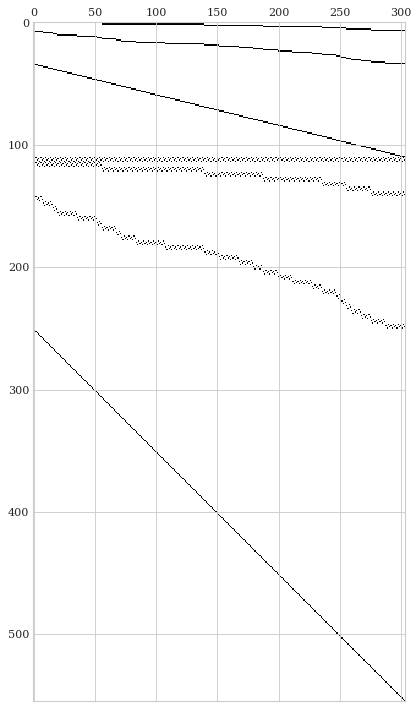

In [ ]:
plt.figure(num=1, figsize=(6, 15), dpi=80, facecolor='w')
plt.spy(data['H'])
plt.show()
plt.close()

#### Checking pre-estimated levels seasons S_bottom

len(dates) 240
len(fdates) 241
data['scols']:= Index(['level', 'spread', 'level_[december]', 'level_[january]'], dtype='object')
data['xcols']:= Index(['month_[11]', 'month_[12]', 'available_mask', 'sample_mask',
       'y_[lag12]', 'y'],
      dtype='object')


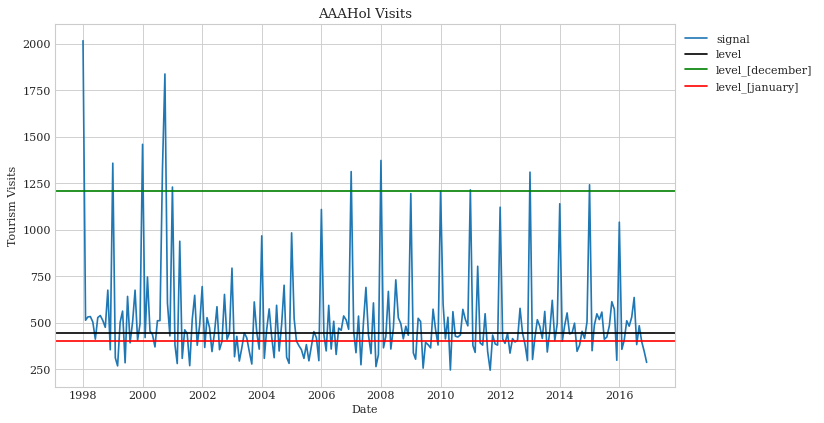

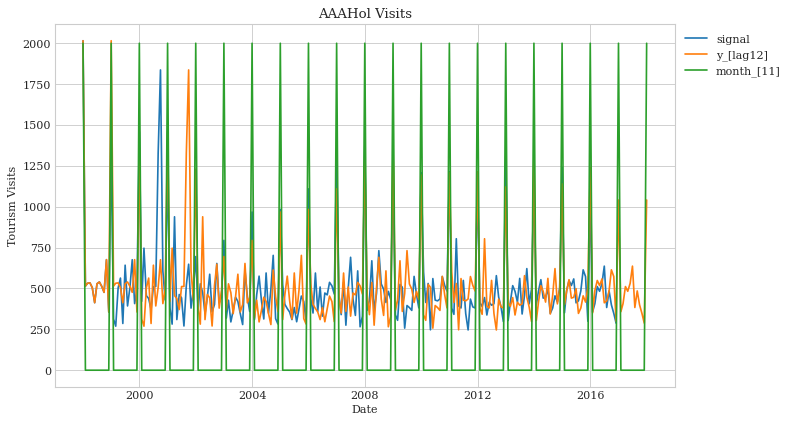

In [ ]:
# Plot S_bottom
dates = data['dates']
fdates = data['fdates']           # Future dates
scols_bottom = data['scols']

print('len(dates)', len(dates))
print('len(fdates)', len(fdates))

# n_groups,n_series,n_features,n_time
Y_bottom = data['Y'].reshape(-1, 228)
X_bottom = data['X']
X_bottom = X_bottom.reshape(-1, X_bottom.shape[2], 241)
S_bottom = data['S'].reshape(-1, data['S'].shape[1])

print("data['scols']:=", data['scols'])
print("data['xcols']:=", data['xcols'])

b_idx = 0
plt.figure(num=1, figsize=(10, 6), dpi=80, facecolor='w')
plt.plot(dates[:228],Y_bottom[b_idx,:], label='signal')
plt.axhline(y=S_bottom[b_idx,0], 
            label='level', color='black')
plt.axhline(y=S_bottom[b_idx,0]*S_bottom[b_idx,2], 
            label='level_[december]', color='green')
plt.axhline(y=S_bottom[b_idx,0]*S_bottom[b_idx,3],
            label='level_[january]', color='red')
plt.title('{} Visits'.format(data["unique_ids"][b_idx]))
plt.ylabel('Tourism Visits')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1, 1), 
           loc='upper left', ncol=1)
plt.show()
plt.close()

plt.figure(num=1, figsize=(10, 6), dpi=80, facecolor='w')
plt.plot(fdates,X_bottom[b_idx,-1,:], label='signal') # 'y_[lag12]'
plt.plot(fdates,X_bottom[b_idx,4,:], label='y_[lag12]') # 'y_[lag12]'
plt.plot(fdates,X_bottom[b_idx,0,:]*2000, label='month_[11]') # 'month_[11]'
plt.title('{} Visits'.format(data["unique_ids"][b_idx]))
plt.ylabel('Tourism Visits')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1, 1), 
           loc='upper left', ncol=1)
plt.show()
plt.close()
# assert 1<0

data['scols_agg']:= Index(['country_[Australia]', 'state_[A]', 'state_[B]', 'state_[C]'], dtype='object')
data['xcols_agg']:= Index(['distance_month', 'y_[total]', 'y_[state]', 'y_[zone]', 'y_[region]'], dtype='object')


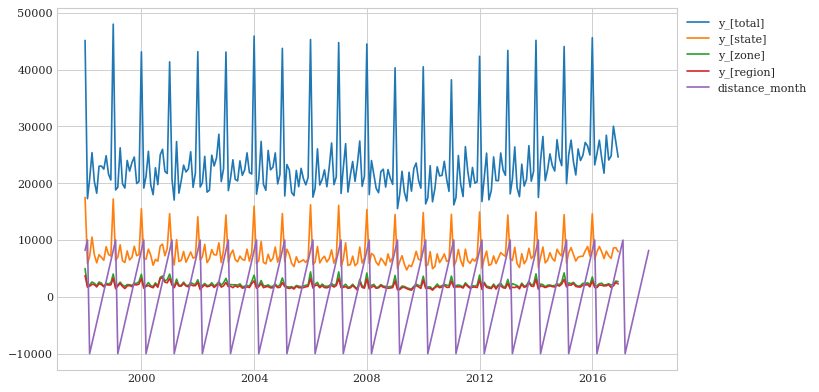

In [ ]:
print("data['scols_agg']:=", data['scols_agg'][:4])
print("data['xcols_agg']:=", data['xcols_agg'])

X_agg = data['X_agg']

a_idx = 0
plt.figure(num=1, figsize=(10, 6), dpi=80, facecolor='w')
plt.plot(fdates,X_agg[a_idx,1,:], label='y_[total]')
plt.plot(fdates,X_agg[a_idx,2,:], label='y_[state]')
plt.plot(fdates,X_agg[a_idx,3,:], label='y_[zone]')
plt.plot(fdates,X_agg[a_idx,4,:], label='y_[region]')
plt.plot(fdates,X_agg[a_idx,0,:]*20_000, label='distance_month')
plt.legend()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()
plt.close()

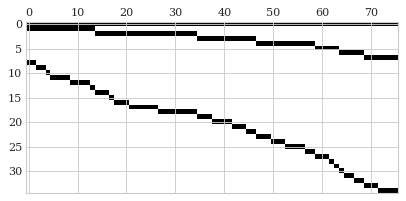

In [ ]:
plt.figure(num=1, figsize=(6, 10), dpi=80, facecolor='w')
plt.spy(data['S_agg'].T)
plt.show()
plt.close()

#### Checking Hierarchically linked data

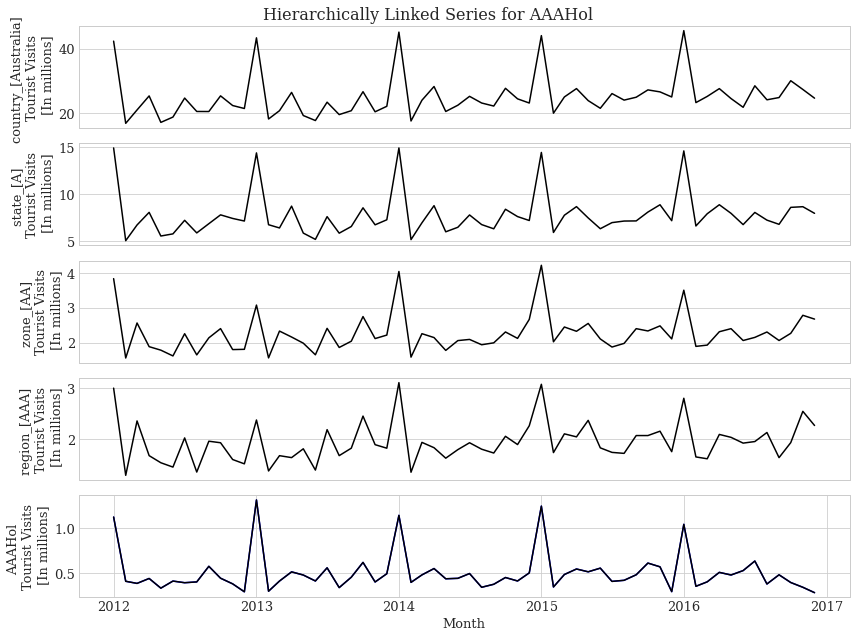

In [ ]:
def plot_hierarchically_linked_data(data, idx, n_years=18, plot_file=None):
    # This plots validate the S/X/Y_bottom
    # We check for the sinchronization of features with Y_bottom
    # We do the same for Y_agg, to check correct linkage
    assert idx < 304 and idx>=0
    
    # Hierarchically linked data and labels
    Y_agg = data['Y_agg'][idx]
    hier_idxs = data['hier_linked_idxs'][idx]
    Y_agg_labels = data['hier_labels'][hier_idxs]
    
    # Base series and its label  n_agg=251 idx \in {0,...,304}
    Y_base = data['Y_hier'][idx + 251]
    Y_base2 = data['Y'][0,0,:]
    
    x_plot = data['dates'][:-12] # Skip future dates    
    label  = data['hier_labels'][idx + 251]
    
    # Creating hierarchically linked series by indexing the upper levels.
    # [Total, State, Zone, Region, P, StateP, ZoneP] [0, 1, 2, 3, 4, 5, 6]
    # [Total, P, HP, HHP] <--> [0, 4, 5, 6]
    n_agg, n_time = Y_agg.shape
    
    assert len(x_plot) == n_time

    fig, axs = plt.subplots(n_agg+1,1, figsize=(12, 9))
    for idx in range(n_agg):        
        axs[idx].plot(x_plot[-12*n_years:], Y_agg[idx,-12*n_years:]/1000, 
                      color = 'black', linewidth=1.5)
        axs[idx].set_ylabel(f'{Y_agg_labels[idx]} \nTourist Visits\n [In millions]', fontsize=13)
        axs[idx].set_xticks([])
        axs[idx].tick_params(labelsize=13)
    
    # Checking that Y_bottom and Y_hier match
    axs[4].plot(x_plot[-12*n_years:], Y_base[-12*n_years:]/1000,
                color = 'blue', linewidth=1.5, label='base')
    axs[4].plot(x_plot[-12*n_years:], Y_base2[-12*n_years:]/1000,
                color = 'black', linewidth=1.5, label='base')    
    
    axs[4].set_xlabel('Month', fontsize=13)
    axs[4].set_ylabel(f'{label} \nTourist Visits\n [In millions]', fontsize=13)
    axs[4].tick_params(labelsize=13)
    
    plt.suptitle(f'Hierarchically Linked Series for {label}', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    if plot_file is not None:
        plt.savefig(plot_file, bbox_inches='tight')
    plt.show()
    
plot_hierarchically_linked_data(data, idx=0, n_years=5, plot_file=None)

#### Checking Geographically linked data

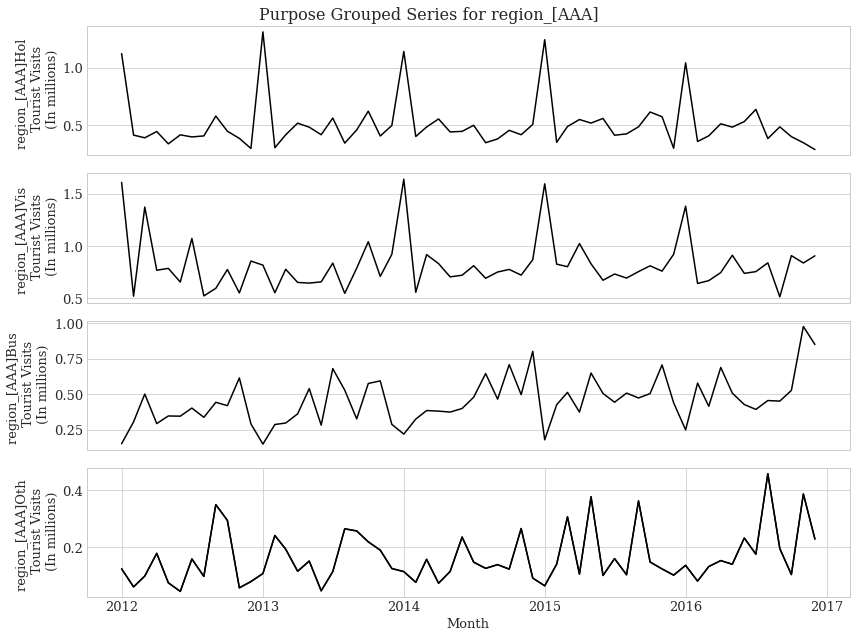

In [ ]:
def plot_region_data(data, region_idx, plot_file=None):
    x_plot = data['dates'][:-12]
    Y_agg  = data['Y_agg'][region_idx] # [country,state,zone,region]
    Y_base = data['Y'][region_idx]
    
    hier_idxs = data['hier_linked_idxs'][region_idx]
    Y_agg_labels = data['hier_labels'][hier_idxs]
    region = Y_agg_labels[3] #[country,state,zone,region,country_p,state_p,...]
    
    n_years = 5
    fig, axs = plt.subplots(4,1, figsize=(12, 9))

    for idx, purpose in enumerate(['Hol', 'Vis', 'Bus', 'Oth']):
        axs[idx].plot(x_plot[-12*n_years:], Y_base[idx,-12*n_years:]/1000, 
                      color = 'black', linewidth=1.5, label=f'{idx}')
        #axs[idx].set_xlabel('Month', fontsize=13)
        axs[idx].set_ylabel(f'{region}{purpose} \n Tourist Visits\n (In millions)', fontsize=13)
        if idx<3:
            axs[idx].set_xticks([])
        axs[idx].tick_params(labelsize=13)  
    
    axs[idx].plot(x_plot[-12*n_years:], Y_base[idx, -12*n_years:]/1000, 
                  color = 'black', linewidth=1.5, label=f'{idx}')
    axs[3].set_xlabel('Month', fontsize=13)
    axs[3].tick_params(labelsize=13)
    
    plt.suptitle(f'Purpose Grouped Series for {region}', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    if plot_file is not None:
        plt.savefig(plot_file, bbox_inches='tight')
    plt.show()
    
plot_region_data(data, region_idx=0)

<a name="cell-4"></a>
## 4. HierTimeseriesDataset Class

In [ ]:
# export
from torch.utils.data import Dataset, DataLoader

In [ ]:
# export
class HierTimeseriesDataset(Dataset):   
    def __init__(self, 
                 # Bottom data
                 Y, X, S,
                 xcols,
                 xcols_hist,
                 xcols_futr,
                 xcols_sample_mask,
                 xcols_available_mask,
                 fdates,
                 # Aggregated data
                 Y_agg, X_agg, S_agg,
                 xcols_agg,
                 xcols_hist_agg,
                 xcols_futr_agg,                 
                 # Generator parameters
                 T0, T, H,
                 lastwindow_mask=False,
                ):
        
        # Assert that raw data has correct series lens
        series_len = [len(Y_agg), len(Y), len(X_agg), len(X), len(S_agg), len(S)]
        assert len(np.unique(series_len))==1, f'Check your series length {series_len}'
        
        # Assert that raw data has correct time lens
        assert Y.shape[-1]>=T0+T and X.shape[-1]>=T0+T+H+1,\
            f'Times (Y.shape={Y.shape[-1]},T0+T={T0+T}), (X.shape={X.shape[-1]}, T0+T+H+1={T0+T+H+1})'
                
        # Bottom data
        self.Y = Y
        self.X = X
        self.S = S
        
        self.xcols      = xcols
        self.xcols_hist = xcols_hist
        self.xcols_futr = xcols_futr
        self.xcols_sample_mask = xcols_sample_mask
        self.xcols_available_mask = xcols_available_mask
        
        # Aggregated data
        self.Y_agg = Y_agg
        self.X_agg = X_agg
        self.S_agg = S_agg
        
        self.xcols_agg = xcols_agg
        self.xcols_hist_agg = xcols_hist_agg
        self.xcols_futr_agg = xcols_futr_agg        
        
        # Feature indexes 
        self.hist_agg_col    = list(xcols_agg.get_indexer(xcols_hist_agg))
        self.futr_agg_col    = list(xcols_agg.get_indexer(xcols_futr_agg))

        self.hist_col        = list(xcols.get_indexer(xcols_hist))
        self.futr_col        = list(xcols.get_indexer(xcols_futr))
        self.sample_mask_col    = xcols.get_loc(xcols_sample_mask)
        self.available_mask_col = xcols.get_loc(xcols_available_mask)
        
        self.fdates = fdates[T0+1:T0+T+H+1]
        
        if lastwindow_mask:
            # Create dummy to identify observations of
            # Y's last H steps (X's last H steps are forecast)
            lastwindow_mask = np.zeros(self.X[:,:,self.sample_mask_col,:].shape)
            lastwindow_mask[:,:,T0+T-H:T0+T] = 1
            self.X[:,:,self.sample_mask_col,:] = lastwindow_mask
        
        # Batch parameters
        self.T0   = T0
        self.T    = T
        self.H    = H
        
    def __len__(self):
        return len(self.Y_agg) 
    
    def __getitem__(self, idx):
        # Parse time indexes
        T0 = self.T0
        T  = self.T
        H  = self.H
        
        # [G,N,C,T]
        s = self.S[idx,:,:]
        x = self.X[idx,:,:,T0:T0+T][:,self.hist_col,:]
        f = self.X[idx,:,:,T0+1:T0+T+H+1][:,self.futr_col,:]
        y = self.Y[idx,:,T0+1:T0+T]
        
        sample_mask    = self.X[idx,:,:,T0+1:T0+T][:,self.sample_mask_col,:]
        available_mask = self.X[idx,:,:,T0+1:T0+T][:,self.available_mask_col,:]
        
        # [G,C,T] Shared features across N
        s_agg    = self.S_agg[idx,:]
        x_agg    = self.X_agg[idx,:,T0:T0+T,][self.hist_agg_col,:]
        f_agg    = self.X_agg[idx,:,T0+1:T0+T+H+1][self.futr_agg_col,:]
        y_agg    = self.Y_agg[idx,:,T0+1:T0+T]

        batch = dict(# Bottom data
                     Y=y, S=s, X=x, F=f,
                     sample_mask=sample_mask,
                     available_mask=available_mask,
                     # Aggregated data
                     Y_agg=y_agg, S_agg=s_agg, X_agg=x_agg, F_agg=f_agg)
            
        #print('\n')
        #print('================== BATCH ==============')
        #for key in batch.keys():
        #    print(f'{key}.shape:\t{batch[key].shape}')
        #print('\n')
        return batch

<a name="cell-5"></a>
## 5. HierTimeseriesDataset Validation

In [ ]:
# from neuralforecast.data.datasets.tourismL import TourismL

# directory = './data/hierarchical/TourismL'
# TourismL.preprocess_data(directory=directory, verbose=False)
# data = TourismL.load_process(directory=directory, verbose=False)

In [ ]:
T = 228-12-12
H = 12

train_dataset = HierTimeseriesDataset(# Bottom data
                                      X=data['X'], 
                                      S=data['S'], 
                                      Y=data['Y'],
                                      xcols=data['xcols'],
                                      xcols_hist=data['xcols_hist'],
                                      xcols_futr=data['xcols_futr'],
                                      xcols_sample_mask=data['xcols_sample_mask'],
                                      xcols_available_mask=data['xcols_available_mask'],
                                      fdates = data['fdates'],
                                      # Aggregated data
                                      X_agg=data['X_agg'], 
                                      S_agg=data['S_agg'], 
                                      Y_agg=data['Y_agg'],
                                      xcols_agg=data['xcols_agg'],
                                      xcols_hist_agg=data['xcols_hist_agg'],
                                      xcols_futr_agg=data['xcols_futr_agg'],
                                      # Generator parameters
                                      T0=0,T=T,H=H)

valid_dataset = HierTimeseriesDataset(# Bottom data
                                      X=data['X'], 
                                      S=data['S'], 
                                      Y=data['Y'],
                                      xcols=data['xcols'],
                                      xcols_hist=data['xcols_hist'],
                                      xcols_futr=data['xcols_futr'],
                                      xcols_sample_mask=data['xcols_sample_mask'],
                                      xcols_available_mask=data['xcols_available_mask'], 
                                      fdates = data['fdates'],
                                      # Aggregated data
                                      X_agg=data['X_agg'], 
                                      S_agg=data['S_agg'], 
                                      Y_agg=data['Y_agg'],
                                      xcols_agg=data['xcols_agg'],
                                      xcols_hist_agg=data['xcols_hist_agg'],
                                      xcols_futr_agg=data['xcols_futr_agg'],
                                      # Generator parameters
                                      T0=24,T=T,H=H,
                                      lastwindow_mask=True)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=3)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=3)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))

for key in train_batch.keys():
    print(f'{key}.shape', train_batch[key].shape)

Y.shape torch.Size([4, 4, 203])
S.shape torch.Size([4, 4, 4])
X.shape torch.Size([4, 4, 1, 204])
F.shape torch.Size([4, 4, 3, 216])
sample_mask.shape torch.Size([4, 4, 203])
available_mask.shape torch.Size([4, 4, 203])
Y_agg.shape torch.Size([4, 4, 203])
S_agg.shape torch.Size([4, 35])
X_agg.shape torch.Size([4, 4, 204])
F_agg.shape torch.Size([4, 1, 216])


### 5.1 Examinate HierTimeSeriesDataset aggregate batch
1. Examinate the hierarchically linked Y_agg series.
2. Examinate the alignment between Y_agg and X_agg_futr.
3. Validate the S_agg dummies generated from H constraints matrix.

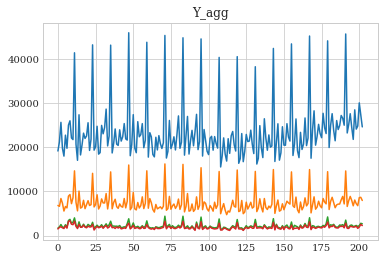

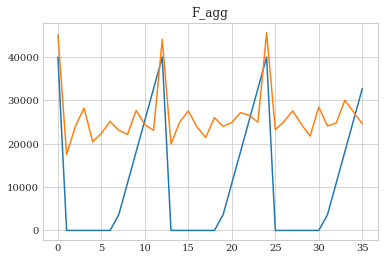

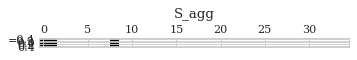

In [ ]:
# Parse batch and filter for first entry
batch = valid_batch
S_agg = batch['S_agg'][0]
Y_agg = batch['Y_agg'][0]
X_agg = batch['X_agg'][0]
F_agg = batch['F_agg'][0]

#---------------- Hierarchical Y_agg ----------------#
plt.plot(Y_agg[0,:])
plt.plot(Y_agg[1,:])
plt.plot(Y_agg[2,:])
plt.plot(Y_agg[3,:])
plt.title('Y_agg')
plt.show()
plt.close()

#---------------- X_agg_futr ----------------#
F_agg = np.maximum(F_agg[0,:]*80000,
                   np.zeros(F_agg[0,:].shape))
plt.plot(F_agg[-36:])
plt.plot(Y_agg[0,-36:])
plt.title('F_agg')
plt.show()
plt.close()

#---------------- S_agg ----------------#
plt.figure(num=1, figsize=(5, 5), dpi=80, facecolor='w')
plt.spy(S_agg[None,:])
plt.title('S_agg')
plt.show()
plt.close()

### 5.2 Examinate HierTimeSeriesDataset bottom batch
1. Examinate the alignment between Y_bottom, S_bottom and X_bottom_futr.
2. Validate batch Seq2Seq structure between X_bottom vs Y_bottom.

S_bottom  torch.Size([4, 4])
Y_bottom  torch.Size([4, 203])
X_bottom  torch.Size([4, 1, 204])
F_bottom  torch.Size([4, 3, 216])
sample_mask  torch.Size([4, 203])


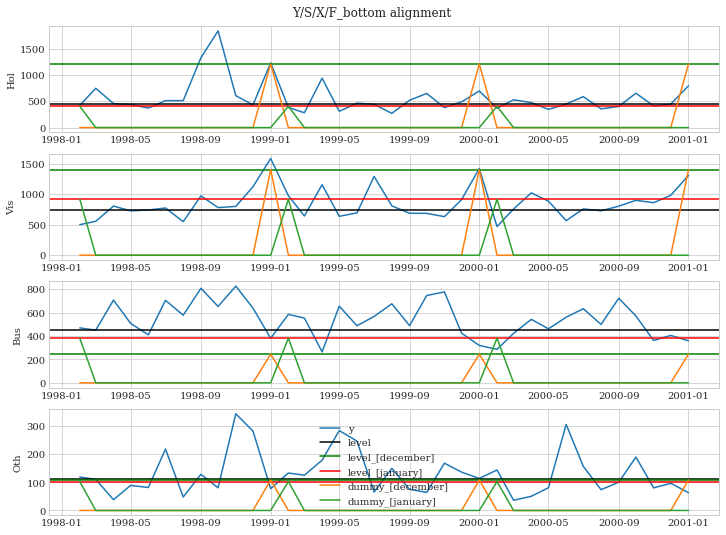

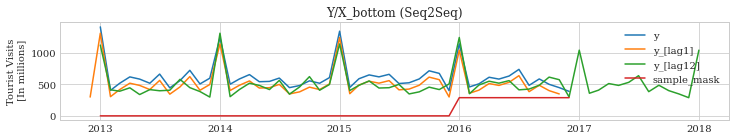

In [ ]:
# Parse batch and filter for first entry
batch = valid_batch
fdates = valid_dataset.fdates
S_bottom = batch['S'][0]
Y_bottom = batch['Y'][0]
X_bottom = batch['X'][0]
F_bottom = batch['F'][0]
sample_mask = batch['sample_mask'][0]

print('S_bottom ', S_bottom.shape)
print('Y_bottom ', Y_bottom.shape)
print('X_bottom ', X_bottom.shape)
print('F_bottom ', F_bottom.shape)
print('sample_mask ', sample_mask.shape)


#---------------- Y/S/X_bottom alignment ----------------#
n_years = 3
fig, axs = plt.subplots(4,1, figsize=(12, 9))

for idx, purpose in enumerate(['Hol', 'Vis', 'Bus', 'Oth']):    
    axs[idx].plot(dates[1:n_years*12+1],Y_bottom[idx,:n_years*12], label='y')
    axs[idx].axhline(y=S_bottom[idx,0],
                label='level', color='black')
    axs[idx].axhline(y=S_bottom[idx,0]*S_bottom[idx,2], 
                label='level_[december]', color='green')
    axs[idx].axhline(y=S_bottom[idx,0]*S_bottom[idx,3],
                label='level_[january]', color='red')
    
    axs[idx].plot(dates[1:n_years*12+1],
                  F_bottom[idx,0,:n_years*12]*S_bottom[idx,0]*S_bottom[idx,2],
                 label='dummy_[december]')
    axs[idx].plot(dates[1:n_years*12+1],
                  F_bottom[idx,1,:n_years*12]*S_bottom[idx,0]*S_bottom[idx,3],
                 label='dummy_[january]')
    axs[idx].set_ylabel(purpose)

plt.suptitle('Y/S/X/F_bottom alignment ', y=0.91)
plt.legend()
plt.show()
plt.close()

#---------------- Y/X_bottom Seq2Seq structure ----------------#
idx = 0
start = 155
end = 203
print('\n')
plt.figure(figsize=(12, 1.8))
plt.plot(fdates[start:end],     Y_bottom[idx,start:end]+100, label='y')
plt.plot(fdates[start-1:end-1], X_bottom[idx,0,start:end], label='y_[lag1]')
plt.plot(fdates[start:end+13],  F_bottom[idx,2,start:end+13], label='y_[lag12]')
plt.plot(fdates[start:end],     sample_mask[idx,start:end]*Y_bottom[idx,-1], label='sample_mask')
plt.ylabel('Tourist Visits\n [In millions]')
plt.title('Y/X_bottom (Seq2Seq)')
plt.legend()
plt.show()
plt.close()